| Team | AUC | MCC |
| --- | --- | --- |
| 2.2 - Artyom, Davit, Lilit | 0.840 | 0.376 |
| 2.5 - Movses, Areg, Sargis  | 0.851 | 0.332 |
| 2.3 - Artur, Narine, Narek | 0.811 | 0.363 |
| 2.4 - Gayane, Yelena, Davit, Shushanik | 0.523 | 0.000 |

In [1]:
from sklearn.cluster import KMeans

In [2]:
import numpy as np
from scipy.stats import multivariate_normal, norm


In [3]:
class GMM:
    def __init__(self, k, method='random_mean_std', max_iter=300, tol=1e-6):
        self.k = k 
        self.method = method
        self.max_iter = max_iter
        self.tol=tol
    
    def init_centers(self, X):
        if self.method == 'random_mean': # fix me
            kmeans = KMeans(n_clusters = self.k)
            mean_arr = np.random.rand(self.k, X.shape[1])
            kmeans.cluster_centers_ = mean_arr
            clusters = kmeans.predict(X)
            cov_arr = []
            pi_arr = []
            for i in range(self.k):
                X_i = X[clusters==i]
                cov_arr.append(np.cov(X_i.T))
                pi_arr.append(X_i.shape[0]/X.shape[0])
            return mean_arr, np.array(cov_arr), np.array(pi_arr)
        
        if self.method == 'random_mean_std':
            mean_arr = np.random.rand(self.k, X.shape[1])
            
            cov_arr = []
            for k in range(self.k):
                cov_mtrx = np.random.rand(X.shape[1], X.shape[1])
                cov_arr.append(cov_mtrx.dot(cov_mtrx.T))
            
            pi_arr = np.random.rand(self.k)
            pi_arr = pi_arr/pi_arr.sum()
            return mean_arr, np.array(cov_arr), pi_arr
        
        if self.method == 'k-means':
            # n - number of datapoints
            # m - number of features
            # k - number of clusters
            # mean_arr.shape == k x m
            # cov_arr.shape == k x m x m
            # pi_arr.shape == 1 x k
            kmeans = KMeans(n_clusters = self.k)
            kmeans.fit(X)
            clusters = kmeans.predict(X)
            mean_arr = kmeans.cluster_centers_
            cov_arr = []
            pi_arr = []
            for i in range(self.k):
                X_i = X[clusters==i]
                cov_arr.append(np.cov(X_i.T))
                pi_arr.append(X_i.shape[0]/X.shape[0])
            return mean_arr, np.array(cov_arr), np.array(pi_arr)
    
        if self.method == 'random_divide':
            idx = np.random.choice(self.k, size=X.shape[0])
            mean_arr = np.zeros((self.k, X.shape[1]))
            cov_arr = np.zeros((self.k, X.shape[1], X.shape[1]))
            pi_arr = np.zeros(self.k)
            for i in range(self.k):
                X_i = X[idx==i]
                mean_arr[i] = X_i.mean(axis=0)
                cov_arr[i] = np.cov(X_i.T)
                pi_arr[i] = X_i.shape[0]/X.shape[0]
            return mean_arr, cov_arr, pi_arr

        if self.method == 'random_gammas':
            gamma_mtrx = np.random.rand(X.shape[0], self.k)
            gamma_mtrx = gamma_mtrx/gamma_mtrx.sum(axis=1)[:, np.newaxis]
            return self.maximization(X, gamma_mtrx)

    def fit(self, X):
        self.mean_arr, self.cov_arr, self.pi_arr = self.init_centers(X)
        prev_loss = float('inf')
        for i in range(self.max_iter):
            gamma_mtrx = self.expectation(X)
            mean_arr, cov_arr, pi_arr = self.maximization(X, gamma_mtrx)
            loss = self.loss(X, mean_arr, cov_arr, pi_arr, gamma_mtrx)
            if abs(loss - prev_loss) < self.tol:
                break
            prev_loss = loss
            self.mean_arr = mean_arr
            self.cov_arr = cov_arr
            self.pi_arr = pi_arr
            
    def loss(self, X, mean, cov, pi, gamma_mtrx):
        log_likelihood = 0
        for i, x in enumerate(X):
            likelihood = 0
            for j in range(self.k):
                likelihood += pi[j] * self.pdf(x, mean[j], cov[j], allow_singular=True)
            log_likelihood += np.log(likelihood)
        loss = -log_likelihood / X.shape[0]
        return loss
    
    def pdf(self, x, mean, cov):
        return multivariate_normal.pdf(x, mean, cov, allow_singular=True)
            
    def expectation(self, X):
        gamma_mtrx = np.zeros((X.shape[0], self.k))
        for i, x in enumerate(X):
            for j in range(self.k):
                gamma_mtrx[i][j] = self.pi_arr[j] * self.pdf(x, self.mean_arr[j], self.cov_arr[j])
            gamma_mtrx[i] = gamma_mtrx[i] / gamma_mtrx[i].sum()
            
        return gamma_mtrx

    def maximization(self, X, gamma_mtrx):
        N_k = gamma_mtrx.sum(axis=0)
        N_k = np.expand_dims(N_k, axis=1) 
        mean_arr = (gamma_mtrx.T @ X) / N_k
        cov_arr = []
        for j in range(self.k):
            X_j = X - mean_arr[j]
            cov_arr.append(((X_j.T * gamma_mtrx[:, j]) @ X_j) / N_k[j])
        pi_arr = N_k / X.shape[0]
        
        return mean_arr, np.array(cov_arr), pi_arr   
    
    def loss(self, X, mean, cov, pi, gamma_mtrx):
        log_likelihood = 0
        for i, x in enumerate(X):
            likelihood = 0
            for j in range(self.k):
                likelihood += pi[j] * self.pdf(x, mean[j], cov[j])
            log_likelihood += np.log(likelihood)
        loss = -log_likelihood / X.shape[0]
        return loss
        
    def predict(self, X):
        return self.expectation(X).argmax(axis=1)
    
    def predict_proba(self, X):
        # return predictions using expectation function
        return 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

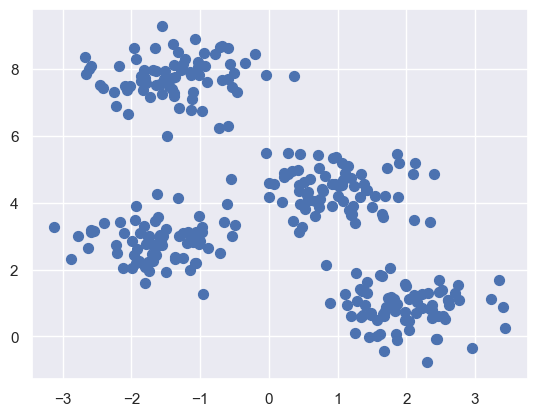

In [5]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [6]:
def plot_gaussian(mean, cov, ax=None, color='b'):
    """
    Plot an ellipse representing a Gaussian distribution with the given mean and covariance matrix.
    """
    if ax is None:
        ax = plt.gca()

    # Check that the covariance matrix is positive definite
    if not np.all(np.linalg.eigvals(cov) > 0):
        raise ValueError('Covariance matrix is not positive definite')
    
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    vals, vecs = np.linalg.eigh(cov)
    # Sort the eigenvalues and eigenvectors in descending order
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:,order]
    
    # Compute the angle of rotation for the ellipse
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    # Create an ellipse object with the mean and covariance matrix
    ellipse = Ellipse(xy=mean, width=np.sqrt(vals[0]), height=np.sqrt(vals[1]), angle=theta, color=color, fill=False)
    ellipse2 = Ellipse(xy=mean, width=2*np.sqrt(vals[0]), height=2*np.sqrt(vals[1]), angle=theta, color=color, fill=False)
    ellipse3 = Ellipse(xy=mean, width=3*np.sqrt(vals[0]), height=3*np.sqrt(vals[1]), angle=theta, color=color, fill=False)

    # Add the ellipse to the plot
    ax.add_artist(ellipse)
    ax.add_artist(ellipse2)
    ax.add_artist(ellipse3)

    
    return ellipse

In [7]:
gmm = GMM(4, method='random_gammas', max_iter=1000, tol=0.001)
gmm.fit(X)

NameError: name 'Ellipse' is not defined

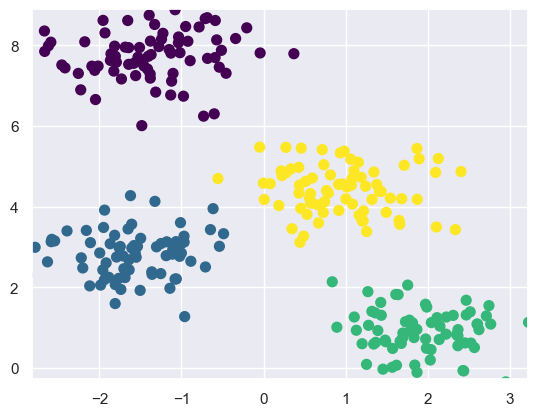

In [8]:
fig, ax = plt.subplots()
ax.set_xlim(gmm.mean_arr[:, 0].min()-3*gmm.cov_arr[:, 0, 0].max(), gmm.mean_arr[:, 0].max()+3*gmm.cov_arr[:, 0, 0].max())
ax.set_ylim(gmm.mean_arr[:, 1].min()-3*gmm.cov_arr[:, 1, 1].max(), gmm.mean_arr[:, 1].max()+3*gmm.cov_arr[:, 1, 1].max())

plt.scatter(X[:, 0], X[:, 1], c=gmm.predict(X), s=50, cmap='viridis')
for k in range(4):
    plot_gaussian(gmm.mean_arr[k], gmm.cov_arr[k], ax=ax)
plt.show()